In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import math

#FIXCONFIG: Add the path to a config file
# global_path = "/root/UR5-Pick-and-Place-Simulation/ml"
global_path = "."
data_path = global_path + "/dev/eval_data/"

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [2]:
def get_records(test_name):
    te_data = []
    path = data_path+test_name
    lf = os.listdir(path)
    records = []
    for f in lf:
        d = read_json_file(path + "/" + f)
        records.append(d)
    return records

In [3]:
#Methods for exploration
def get_ranges(records):
    
    x_r, y_r, z_r, v_r = [inf,-inf],[inf,-inf],[inf,-inf],[inf,-inf]
    for r in records:
        d = np.array(r['data'])
        x_r = [min(x_r[0], np.min(d[:,0])),max(x_r[1], np.max(d[:,0]))]
        y_r = [min(y_r[0], np.min(d[:,1])),max(y_r[1], np.max(d[:,1]))]        
        z_r = [min(z_r[0], np.min(d[:,2])),max(z_r[1], np.max(d[:,2]))]        
        v_r = [min(v_r[0], np.min(d[:,3])),max(v_r[1], np.max(d[:,3]))]   
    return {
        'x': x_r,
        'y': y_r,
        'z': z_r,
        'v': v_r
    }

In [4]:
rec_tD = get_records("t_D")
rec_tEV = get_records("t_EV")
rec_tDEV = get_records("t_DEV")

In [5]:
tR = get_records("t_R")

In [16]:
get_ranges(rec_tR)

{'x': [-0.5989385349841833, 0.6767176047857195],
 'y': [0.18342754580490503, 0.7184191870983871],
 'z': [0.11782123353679215, 0.5318305577613782],
 'v': [0.0, 1.7523761490807963]}

In [10]:
# Parameters
inf = 1e8
W,L,H = 10,21,3
x_range = [-0.75, 0.83]
y_range = [0.02, 0.86]
z_range = [0.10, 0.55]
v_range = [0.0, 2.0]

In [13]:
def is_outlier(rec):
    xin =  x_range[0] <= rec[0] <= x_range[1] 
    yin =  y_range[0] <= rec[1] <= y_range[1] 
    zin =  z_range[0] <= rec[2] <= z_range[1]
    vin =  v_range[0] <= rec[3] <= v_range[1]
    return not zin or not yin or not xin or not vin

def get_outliers(records):
    outs = []
    cnt = 0
    clean_records = []
    for r in records:
        clean = True
        for item in r['data']:
            if is_outlier(item):
                clean = False
                outs.append(item)
            else:
                cnt += 1
        if clean:
            clean_records.append(r)
    print(f"Clean # is {cnt} and # clean records {len(clean_records)}")
    return clean_records,outs


# def clean_outliers(records):
#     outs = []
#     cnt = 0
#     for r in records:
#         for item in r['data']:
#             if is_outlier(item):
#                 outs.append(item)
#             else:
#                 cnt += 1
#     return outs

In [14]:
X = get_outliers(tR)

Clean # is 50712 and # clean records 91


In [15]:
rec_tR = X[0]

In [17]:
# Methods for extraction
def get_vel_index(record):
    # returns vi form (0 to V-1)
    thresholds = [0.67,1.33,inf] #FIXME: Compute the actual velocity ranges
    v = record[3]
    for i,t in enumerate(thresholds):
        if v < t:
            return i

def get_pos_index(record):
    global W,L,H
    x,y,z = record[:3]
    w_pct = (x-x_range[0])/(x_range[1] - x_range[0])
    wi = math.floor(w_pct * W)
    l_pct = (y-y_range[0])/(y_range[1] - y_range[0])
    li = math.floor(l_pct * L)
    h_pct = (z-z_range[0])/(z_range[1] - z_range[0])
    hi = math.floor(h_pct * H)
    return wi,li,hi
    

def get_time_elapsed(record):
    return record['time_elapsed']


In [18]:
def run_evol_matrix(records):
    # Record evolution metrics and return the final matrix
    M = np.zeros((W+2,L+2,H+2),dtype='int8')
    num_covered_cells = []
    te_data = []
    cov_cells = 0
    for record in records:
        for r in record['data']:
            v = get_vel_index(r)
            pos = get_pos_index(r)
#             print(f"The record {r[:4]} got the cell {pos} | vel {v}")
#             print(f"Vel {v} | Marking with {1<<v}")
            M[pos] |= 1<<(v)
            # The velocities are stored in a binary signature: 100 => only the second highest (fastest) velocity range was covered
            # Potential metric: how many cells have non zero velocity: sum(M>0)
            cov_cells = np.sum(M>0)
        num_covered_cells.append(cov_cells)
        te_data.append(record['time_elapsed'])
        # TODO: Add more Metrics to be plot

    d = {
        "matrix": M,
        "Covered Cells": num_covered_cells,
        "Time Elapsed": te_data
    }
    return d

def generate_plots(D):
    # plot time elapsed
    te_data = D["Covered Cells"]
    print(D)
    plt.scatter(range(len(te_data)), te_data)
    # plt.xticks([2,4,6,8,10,12,14,16,18,20])
#     plt.xlabel("Test Case #")
#     plt.ylabel("Time Elapsed (seconds)")
    plt.grid()
    plt.show()

In [19]:
md = run_evol_matrix(rec_tD)
mev = run_evol_matrix(rec_tEV)
mdev = run_evol_matrix(rec_tDEV)
mr = run_evol_matrix(rec_tR)

In [67]:
len(mdev['Covered Cells'])

95

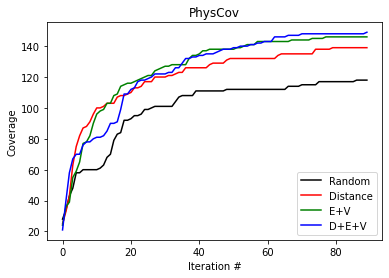

In [21]:
th = 90
X = np.arange(0, th, 1.0) 

# Assign variables to the y axis part of the curve 
cov_r = mr['Covered Cells'][:th]
cov_d = md['Covered Cells'][:th]
cov_ev = mev['Covered Cells'][:th]
cov_dev = mdev['Covered Cells'][:th]

# Plotting both the curves simultaneously 
plt.plot(X, cov_r, color='k', label='Random') 
plt.plot(X, cov_d, color='r', label='Distance') 
plt.plot(X, cov_ev, color='g', label='E+V') 
plt.plot(X, cov_dev, color='b', label='D+E+V') 
  
# Naming the x-axis, y-axis and the whole graph 
plt.xlabel("Iteration #") 
plt.ylabel("Painted cells") 
plt.title("Number of painted cells") 
  
# Adding legend, which helps us recognize the curve according to it's color 
plt.legend() 
# plt.figsize(5)
# To load the display window 
plt.show() 